In [1]:
import base64
import io
import os
import time

from IPython.core.display import HTML
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from models.config import PreprocessingConfig
from models.tts.delightful_tts.delightful_tts_refined import DelightfulTTS
from models.vocoder.univnet import UnivNet
from training.loss import Metrics
from training.preprocess import TacotronSTFT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_rate = 22050

## Add the checkpoints to the `/checkpoints` folder and choose the appropriate version

In [2]:
# Checkpoints to use for demo
checkpoint_name = "logs_new_training_libri-360-swa_19_sec_epoch=190-step=70670"
checkpoint_univnet = "epoch=23-step=11616"


# checkpoint_path = f"./logs_100/{checkpoint_name}.ckpt"
# checkpoint_path = f"./logs_360_energy/{checkpoint_name}.ckpt"
# checkpoint_path = f"./logs/{checkpoint_name}.ckpt"
checkpoint_path = f"./checkpoints/{checkpoint_name}.ckpt"
checkpoint_path_univnet = f"./checkpoints/{checkpoint_univnet}.ckpt"

# Dataset url to use for demo
# dataset_url = "train-clean-100"
dataset_url = "train-clean-100"

### Load from the checkpoint

In [3]:
model = DelightfulTTS.load_from_checkpoint(checkpoint_path, strict=False).to(device)
model.eval()

model.vocoder_module = UnivNet()
model.vocoder_module.eval()

print(f"Loaded checkpoint: {checkpoint_path}")

preprocess_config = PreprocessingConfig("english_only")
tacotronSTFT = TacotronSTFT(
    filter_length=preprocess_config.stft.filter_length,
    hop_length=preprocess_config.stft.hop_length,
    win_length=preprocess_config.stft.win_length,
    n_mel_channels=preprocess_config.stft.n_mel_channels,
    sampling_rate=preprocess_config.sampling_rate,
    mel_fmin=preprocess_config.stft.mel_fmin,
    mel_fmax=preprocess_config.stft.mel_fmax,
    center=False,
)
tacotronSTFT = tacotronSTFT.to(device)

/home/you/anaconda3/envs/tts_framework/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.2


Loaded checkpoint: ./checkpoints/logs_new_training_libri-360-swa_19_sec_epoch=190-step=70670.ckpt


### Load the speakers list

In [4]:
# text_tts = """
# Casablanca: “But what about us?”
# “We’ll always have Paris.”
# The Wizard of Oz: “Lions? And Tigers? And Bears?”
# “Oh my!”
# Star Wars (A New Hope): “He’s almost in range.”
# “That’s no moon; it’s a space station.”
# Love Story: “Jenny, I’m sorry.”
# “Don’t. Love means never having to say you’re sorry.”
# No Country for Old Men: “Look, I need to know what I stand to win.”
# “Everything.”
# Forrest Gump: “I thought I’d try out my sea legs.”
# “But you ain’t got no legs, Lieutenant Dan.”
# Toy Story: “Buzz, you’re flying!”
# “This isn’t flying; this is falling with style.”
# As the snake shook its head, a deafening shout behind Harry made both of them jump.
# ‘DUDLEY! MR DURSLEY! COME AND LOOK AT THIS SNAKE! YOU WON’T BELIEVE WHAT IT’S DOING!’
# """

text_tts = """
Casablanca: “But what about us?”
“We’ll always have Paris.”
The Wizard of Oz: “Lions? And Tigers? And Bears?”
“Oh my!”
"""

model.vocoder_module.to(device)

metrics = Metrics()
text_demo_with_metrics = []

speakers_df = pd.read_csv(
    "./datasets_cache/LIBRITTS/LibriTTS/speakers.tsv",
    sep="\t",
    names=["READER", "GENDER", "SUBSET", "NAME"],
)

subsets = ["train-clean-100", "train-clean-360", "train-other-500"]

speakers = speakers_df[speakers_df['SUBSET'].isin(subsets)]
i = 0
for speaker in speakers.to_dict("records"):
    speaker_id = speaker["READER"]
    speaker_name = speaker["NAME"]
    gender = speaker["GENDER"]
    subset = speaker["SUBSET"]

    with torch.no_grad():
        speaker_id_ = torch.tensor([int(speaker_id)], device=device)
        start_time = time.time()
        wav = model.forward(text_tts, speaker_id_)
        end_time = time.time()
        (
            ermr,
            jitter,
            shimmer,
        ) = metrics.wav_metrics(wav.unsqueeze(0))
        execution_time = round(end_time - start_time, 2)

        mel = tacotronSTFT.get_mel_from_wav(wav)

        text_demo_with_metrics.append({
            "speaker_id": speaker_id,
            "speaker_name": speaker_name,
            "gender": gender,
            "subset": subset,
            "wav": wav.detach().cpu().numpy(),
            "execution_time": execution_time,
            "mel": mel.detach().cpu().numpy(),
            "ermr": ermr,
            "jitter": jitter,
            "shimmer": shimmer,
        })
    torch.cuda.empty_cache()
    i += 1
    if i == 10:
        break
text_demo_with_metrics[:2]


[{'speaker_id': '14',
  'speaker_name': 'Kristin LeMoine',
  'gender': 'F',
  'subset': 'train-clean-360',
  'wav': array([-1.1066194e-03, -1.2291268e-03, -1.2665864e-03, ...,
         -1.6089948e-04, -5.4736156e-05, -1.9340776e-05], dtype=float32),
  'execution_time': 0.55,
  'mel': array([[ -3.8787737,  -3.9952457,  -3.599357 , ...,  -4.638753 ,
           -4.8026605,  -5.2995462],
         [ -4.1449203,  -4.2112904,  -4.4314375, ...,  -4.5519943,
           -4.8298426,  -5.2646937],
         [ -6.2360787,  -5.128247 ,  -5.4786377, ...,  -5.7916784,
           -5.715713 ,  -5.6875496],
         ...,
         [ -8.87533  ,  -8.65131  ,  -8.457996 , ...,  -8.773915 ,
           -9.335076 ,  -9.881855 ],
         [ -9.282959 ,  -9.107319 ,  -8.83791  , ...,  -8.9328785,
           -9.385317 ,  -9.7847   ],
         [-10.3639   , -10.311022 , -10.22998  , ..., -10.100846 ,
          -10.546519 , -10.723772 ]], dtype=float32),
  'ermr': 15.889996528625488,
  'jitter': 0.014177183620631695

In [9]:
def plot_spectrogram(mel: np.ndarray):
    r"""Plots the mel spectrogram."""
    plt.figure(dpi=80, figsize=(10, 3))

    img = librosa.display.specshow(mel, x_axis="time", y_axis="mel", sr=sample_rate)
    plt.title("Spectrogram")
    plt.colorbar(img, format="%+2.0f dB")

    # Save the plot to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    # Convert the BytesIO object to a base64 string
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close()

    return img_str

def gen_table(text_demo_with_metrics: list):
    # Initialize an empty string to store the HTML
    html = "<table border='1'>"

    html += f"<h4>TTS: </h4> {text_tts}"

    html += "<h4>Speakers: </h4>"
    html += """<tr>
        <th>SpeakerID</th>
        <th>Speaker Name</th>
        <th>Gender</th>
        <th>Subset</th>
        <th>Audio</th>
        <th>InfTime</th>
        <th>ermr</th>
        <th>jitter</th>
        <th>shimmer</th>
        <th>spec</th>
    </tr>"""

    for row in text_demo_with_metrics:
        # Speaker info
        speaker_id = row["speaker_id"]
        speaker_name = row["speaker_name"]
        gender = row["gender"]
        subset = row["subset"]
        execution_time = row["execution_time"]

        # Waveforms and mel spectrogram
        wav = row["wav"]
        mel = row["mel"]

        # Metrics
        ermr = row["ermr"]
        jitter = row["jitter"]
        shimmer = row["shimmer"]

        # Round the metrics to 3 decimal places
        metrics = [round(x, 3) for x in [ermr, jitter, shimmer]]

        audio = Audio(wav, rate=sample_rate, autoplay=False)

        # Generate the spectrogram plot
        fig = plot_spectrogram(mel)

        # Add a row to the HTML table
        html += f"""<tr>
            <td>{speaker_id}</td>
            <td>{speaker_name}</td>
            <td>{gender}</td>
            <td>{subset}</td>
            <td>{audio._repr_html_()}</td>
            <td>{execution_time}</td>
            <td>{metrics[0]}</td>
            <td>{metrics[1]}</td>
            <td>{metrics[2]}</td>
            <td><img src='data:image/png;base64,{fig}' /></td>
        </tr>"""

    # Close the HTML table
    html += "</table>"

    return HTML(html)



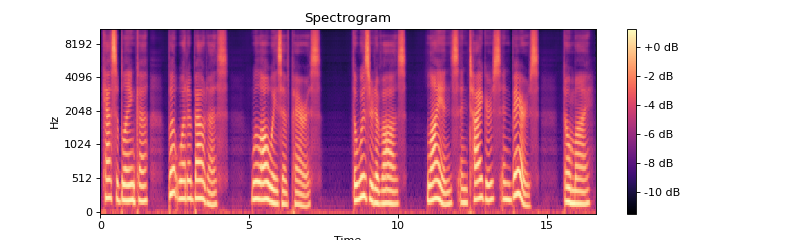

In [10]:
df = pd.DataFrame(text_demo_with_metrics)
# Order by energy, ascending
gen_table(df.sort_values(by=["ermr"], ascending=False)[:1].to_dict("records"))

In [11]:
# Get the unique cluster labels
df_ermr_sorted = df.sort_values(by="ermr")
metrics = ["ermr", "jitter", "shimmer"]

# Split the DataFrame into chunks of size 100
chunks = df_ermr_sorted.groupby(df_ermr_sorted.index // 100)

demo_dirname = f"logs/{dataset_url}_{checkpoint_name}"
os.makedirs(demo_dirname, exist_ok=True)

# Loop over the chunks
for i, chunk in chunks:
    result = ""
    # Select the relevant columns
    chunk_ = chunk["speaker_id", "distance", *metrics]

    # Add header
    result += f"<h3>Chunk #{i}: </h3>"

    # Describe the chunk
    result += chunk_.describe().to_html()

    result += f"<h3>Chunk #{i} audio data: </h3>"
    # Generate and display the table for the chunk
    result += gen_table(chunk.to_dict("records")).data # type: ignore

    # Save result as HTML
    with open(f"{demo_dirname}/chunk_{i}.html", "w") as f:
        f.write(result)